In [282]:
%load_ext autoreload
%autoreload 2

import os
from pprint import pprint

from math import sqrt
import pickle
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D

print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/matthew/git/cadc_testing/uncertainty_eval


In [283]:
datasets = ['KITTI', 'CADC', 'NuScenes']
data_set_mode = datasets[0]
NETWORK_VAR_AVAILABLE = True
logdir = '/home/matthew/git/cadc_testing/pcdet_output/output_pkls/spatial_features'

feats_dict_list = []
head_output_path_list = []

if data_set_mode == 'KITTI':
    dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/kitti'
    feats_dict_list.append(os.path.join(logdir, '000006_spatial_features_input_input.pkl'))
    feats_dict_list.append(os.path.join(logdir, '000006_spatial_features_input_blank.pkl'))
    feats_dict_list.append(os.path.join(logdir, '000006_spatial_features_blank_input.pkl'))
    feats_dict_list.append(os.path.join(logdir, '000006_spatial_features_blank_blank.pkl'))
    head_output_path_list.append(os.path.join(logdir, '000001_head_1_input_blank.pkl'))
    head_output_path_list.append(os.path.join(logdir, '000001_head_2_input_blank.pkl'))
#     head_output_path_list.append(os.path.join(logdir, '000001_head_1_blank_input.pkl'))
#     head_output_path_list.append(os.path.join(logdir, '000001_head_2_blank_input.pkl'))
    gts_path = os.path.join(logdir, 'kitti_infos_val.pkl')
elif data_set_mode == 'CADC':
    dataset_path = '/home/matthew/git/cadc_testing/WISEOpenLidarPerceptron/data/cadc'
    preds_path = os.path.join(logdir, 'cadc_pp_baseline.pkl')
    gts_path = os.path.join(logdir, 'cadc_infos_val.pkl')
elif data_set_mode == 'NuScenes':
    dataset_path = '/run/user/1000/gvfs/sftp:host=wisebob.eng.uwaterloo.ca,user=mapitrop/data/NuScenes/v1.0-trainval'
    preds_path = os.path.join(logdir, 'nuscenes/nuscenes_pp_baseline_20pc.pkl')
    gts_path = os.path.join(logdir, 'nuscenes/nuscenes_infos_10sweeps_val.pkl')

In [181]:
feats_dicts_list = []
for feats_dict_path in feats_dict_list:
    with open(feats_dict_path, 'rb') as f:
        feats_dicts = pickle.load(f)
    feats_2x = feats_dicts['spatial_features_2x'][:, :, 8:-8, 8:-8]
    feats_4x = feats_dicts['spatial_features_4x'][:, :, 8:-8, 8:-8]
    feats_8x = feats_dicts['spatial_features_8x'][:, :, 8:-8, 8:-8]
    feats_list = [feats_2x, feats_4x, feats_8x]
    feats_dicts_list.append(feats_list)

In [182]:
row_titles = ['input+input', 'input+blank', 'blank+input', 'blank+blank']
column_titles = ['spatial_features_2x', 'spatial_features_4x','spatial_features_8x']

n_rows = len(feats_dicts_list)
n_cols = 3

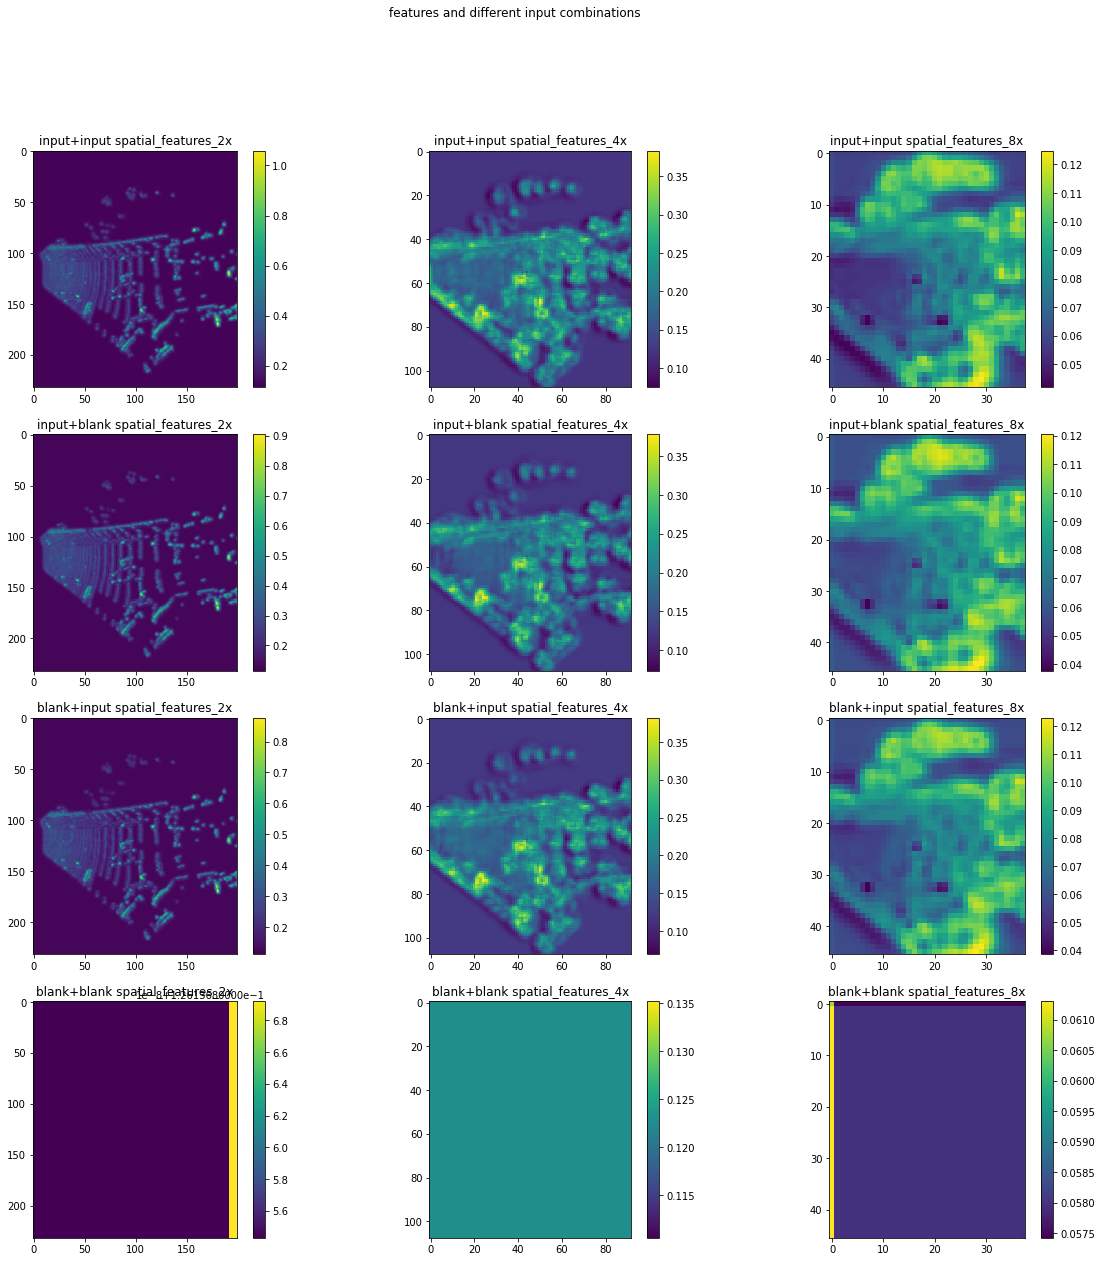

In [183]:

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = torch.mean(feats, dim=(0,1))

        ax = axes[row_num][col_num]
        im = ax.imshow(test, interpolation='none')
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])
        plt.colorbar(im,ax=ax)

fig.suptitle('features and different input combinations')
plt.show()

RuntimeError: Can only calculate the mean of floating types. Got Int instead.

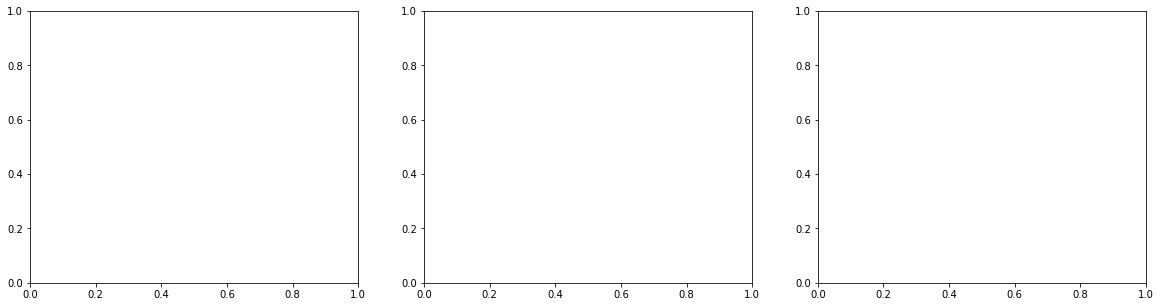

In [292]:

fig, axes = plt.subplots(1, n_cols, figsize=(20,5))

row_num = 1

feats_list_input_blank = feats_dicts_list[row_num]
feats_list_blank_input = feats_dicts_list[row_num +1]
for col_num in range(n_cols):
    A = torch.mean(feats_list_input_blank[col_num], dim=(0,1))
    B = torch.mean(feats_list_blank_input[col_num], dim=(0,1))
    subtraction = A - B

    ax = axes[col_num]
    im = ax.imshow(subtraction, interpolation='none')
    ax.set_title(column_titles[col_num])
    plt.colorbar(im,ax=ax)

fig.suptitle('input+blank mean subtract blank+input mean')
plt.show()

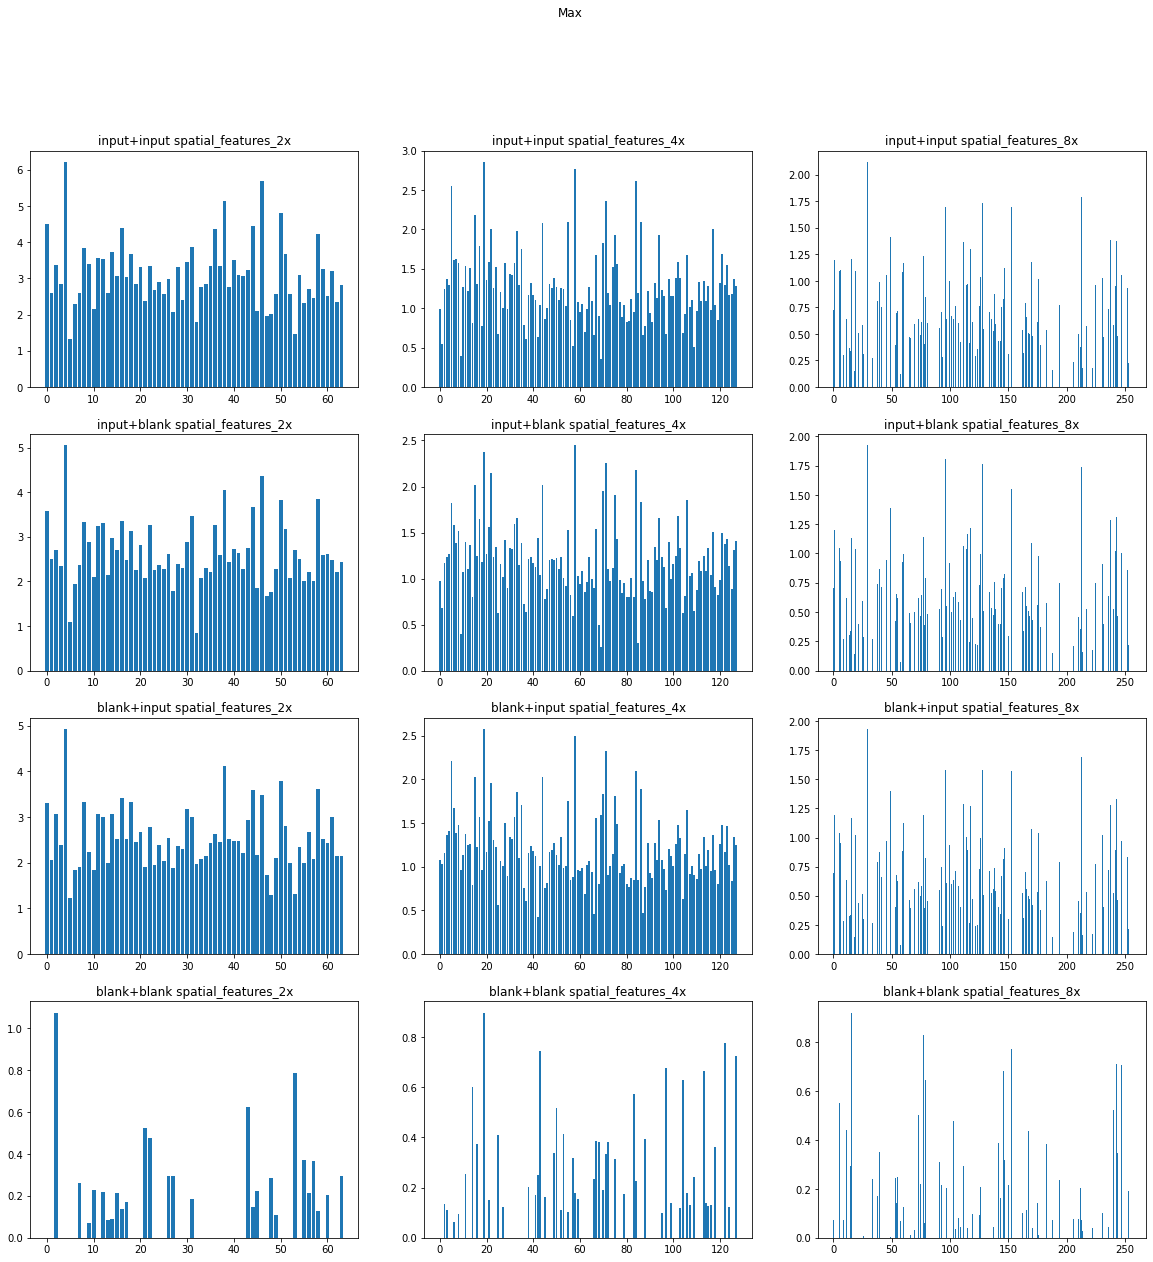

In [109]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = torch.amax(feats, dim=(0, 2,3))

        ax = axes[row_num][col_num]
        ax.bar(x=np.arange(0,len(test)), height=test)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])

fig.suptitle('Max')
plt.show()

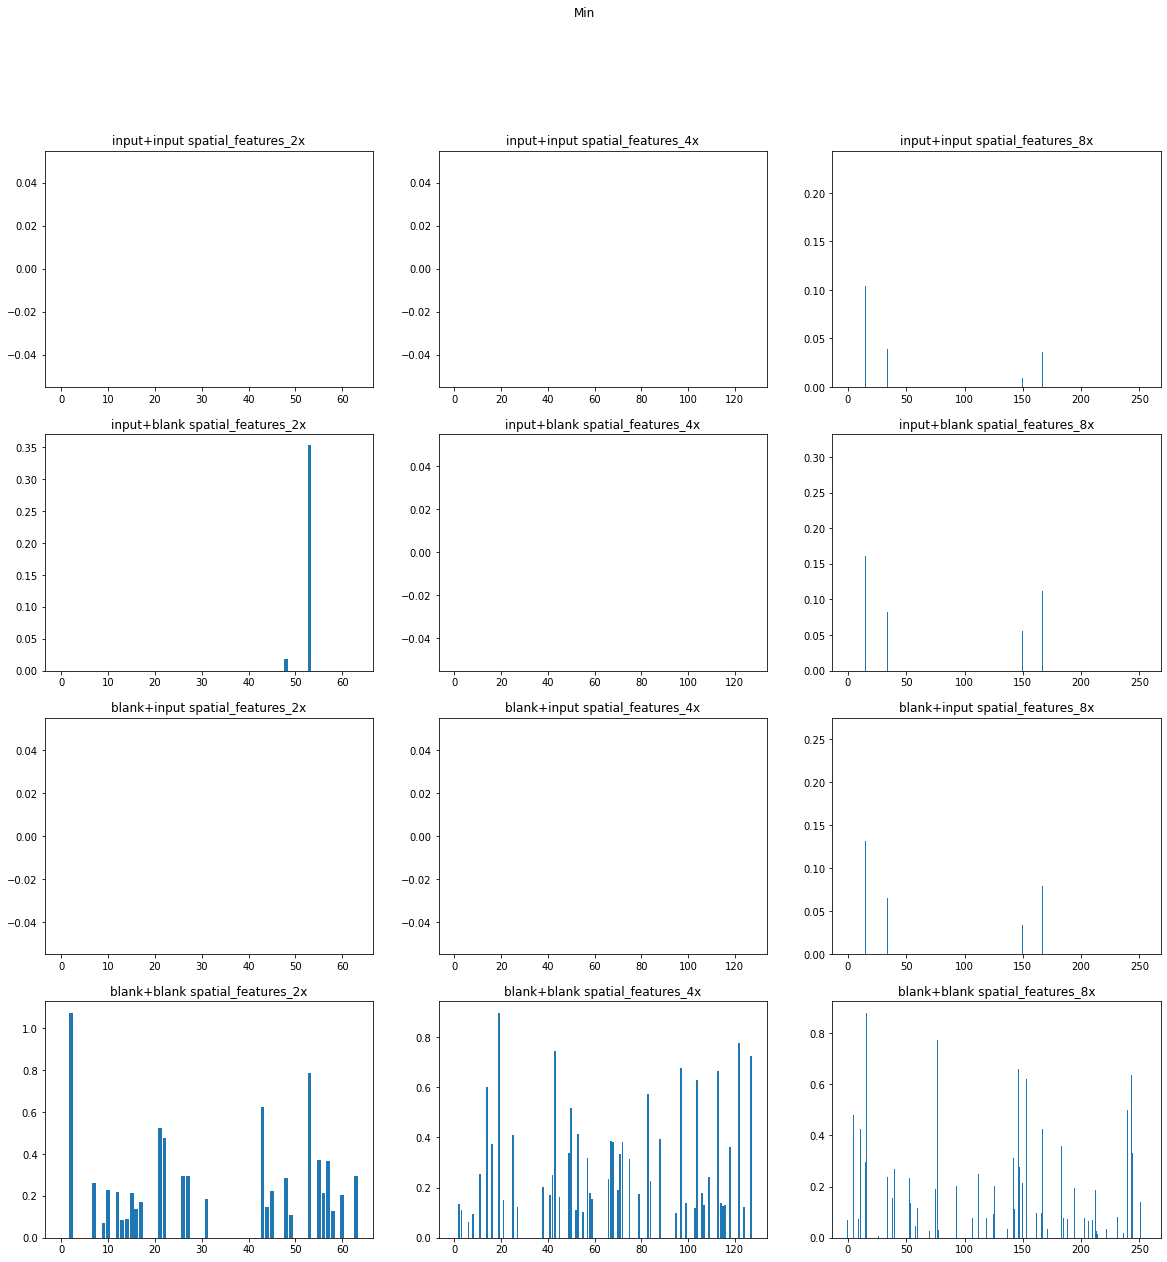

In [110]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = torch.amin(feats, dim=(0, 2,3))

        ax = axes[row_num][col_num]
        ax.bar(x=np.arange(0,len(test)), height=test)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])

fig.suptitle('Min')
plt.show()

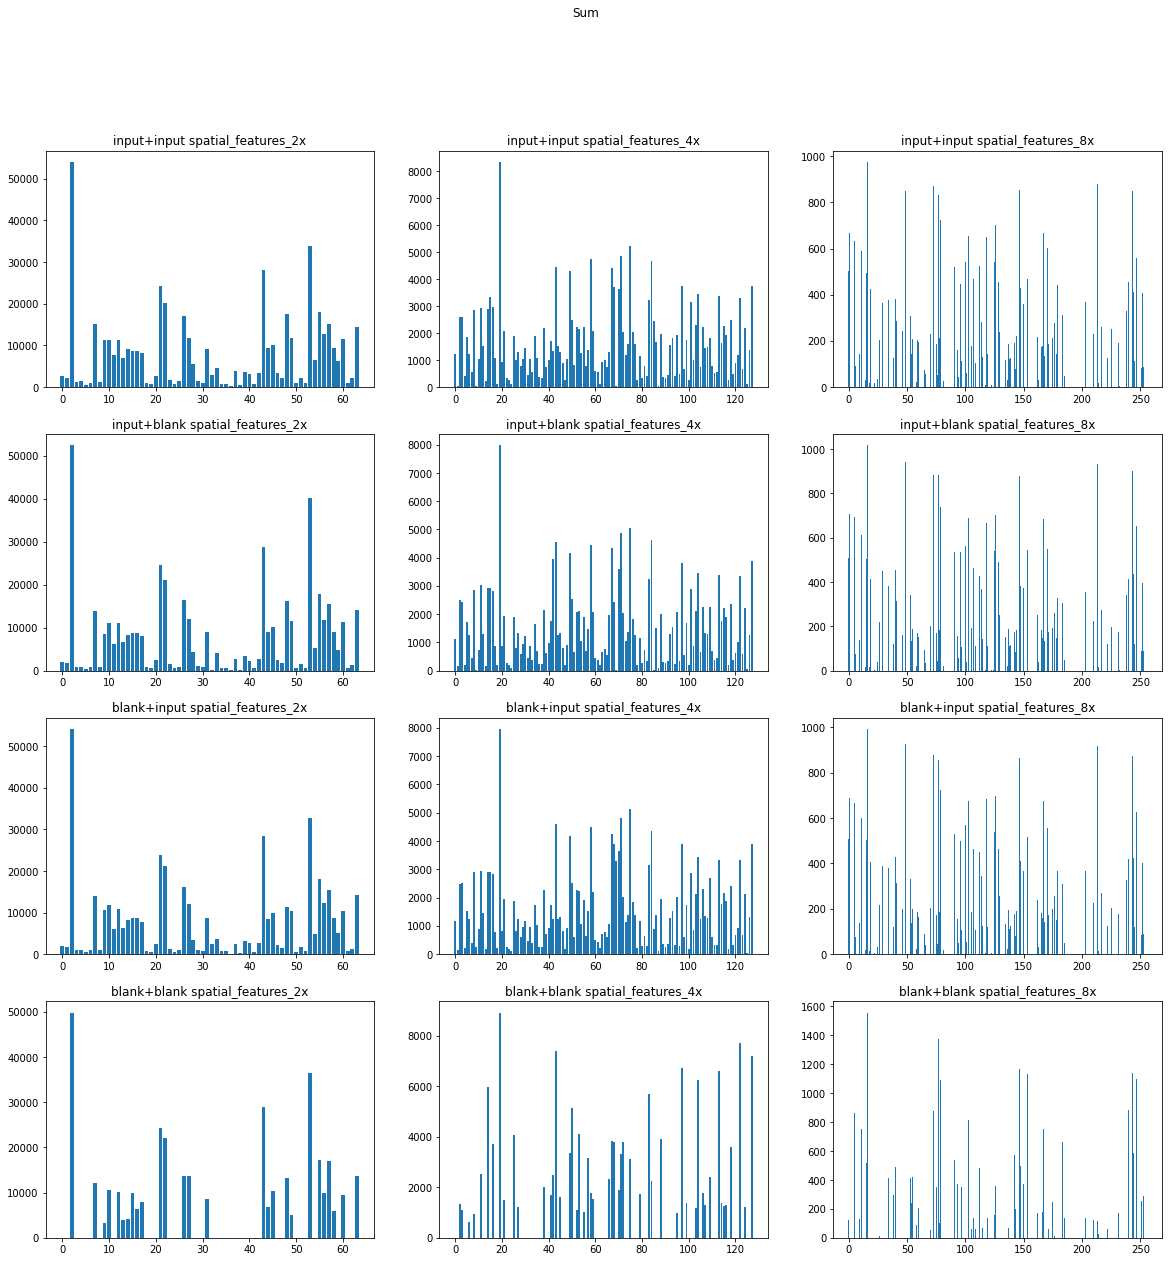

In [111]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = torch.sum(feats, dim=(0, 2,3))

        ax = axes[row_num][col_num]
        ax.bar(x=np.arange(0,len(test)), height=test)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])

fig.suptitle('Sum')
plt.show()

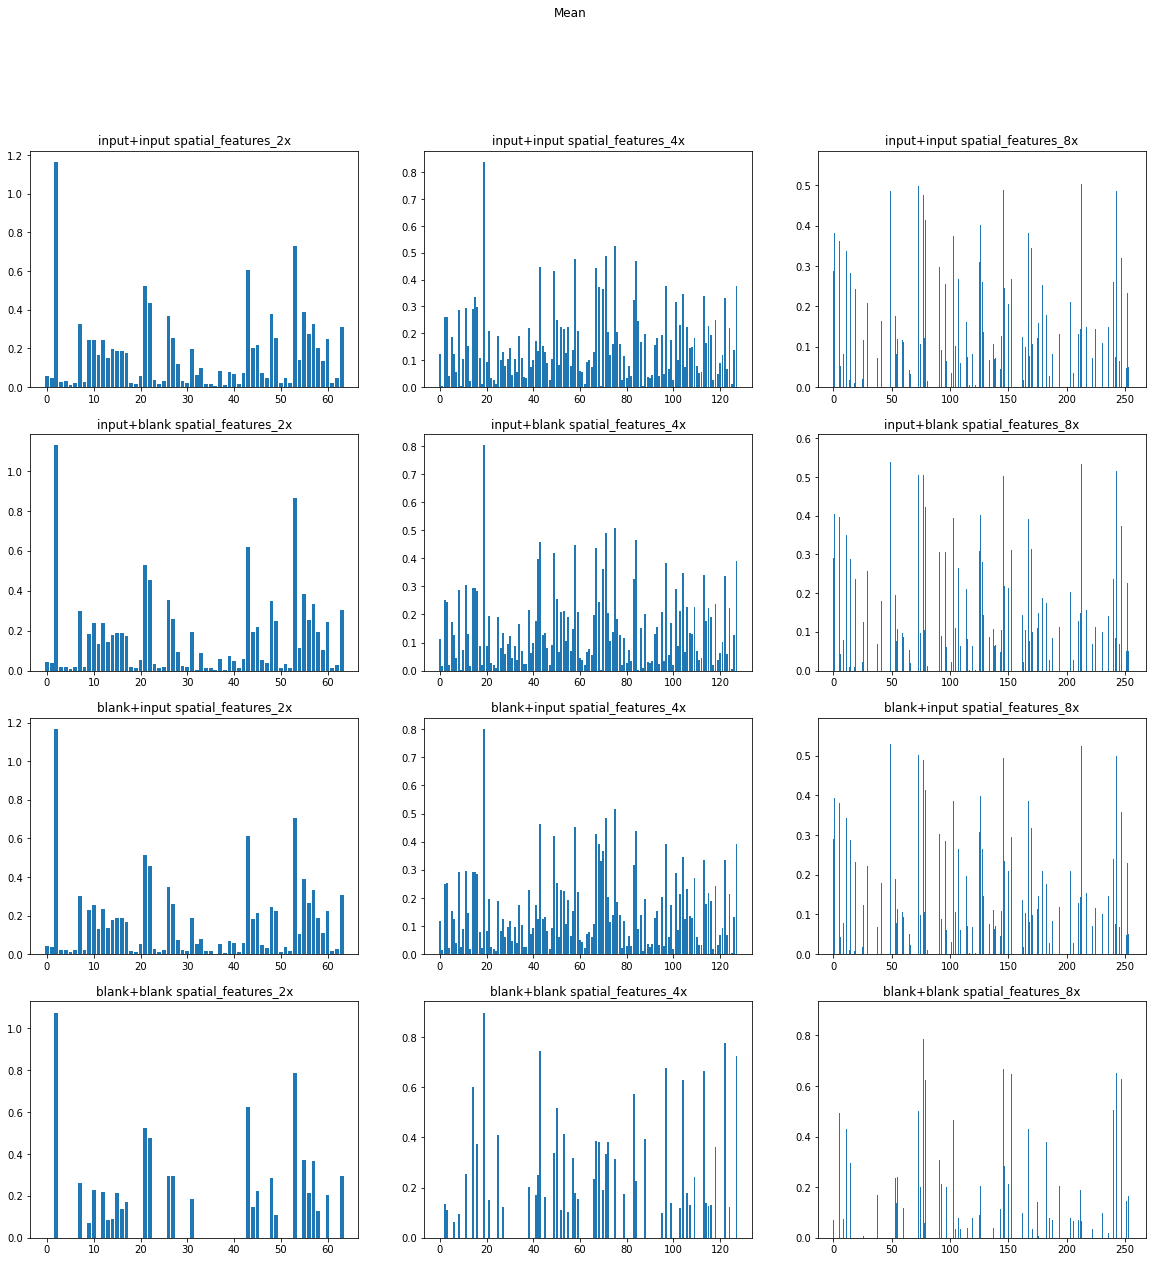

In [112]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = torch.mean(feats, dim=(0, 2,3))

        ax = axes[row_num][col_num]
        ax.bar(x=np.arange(0,len(test)), height=test)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])

fig.suptitle('Mean')
plt.show()

tensor(53)
tensor(42)
tensor(2)


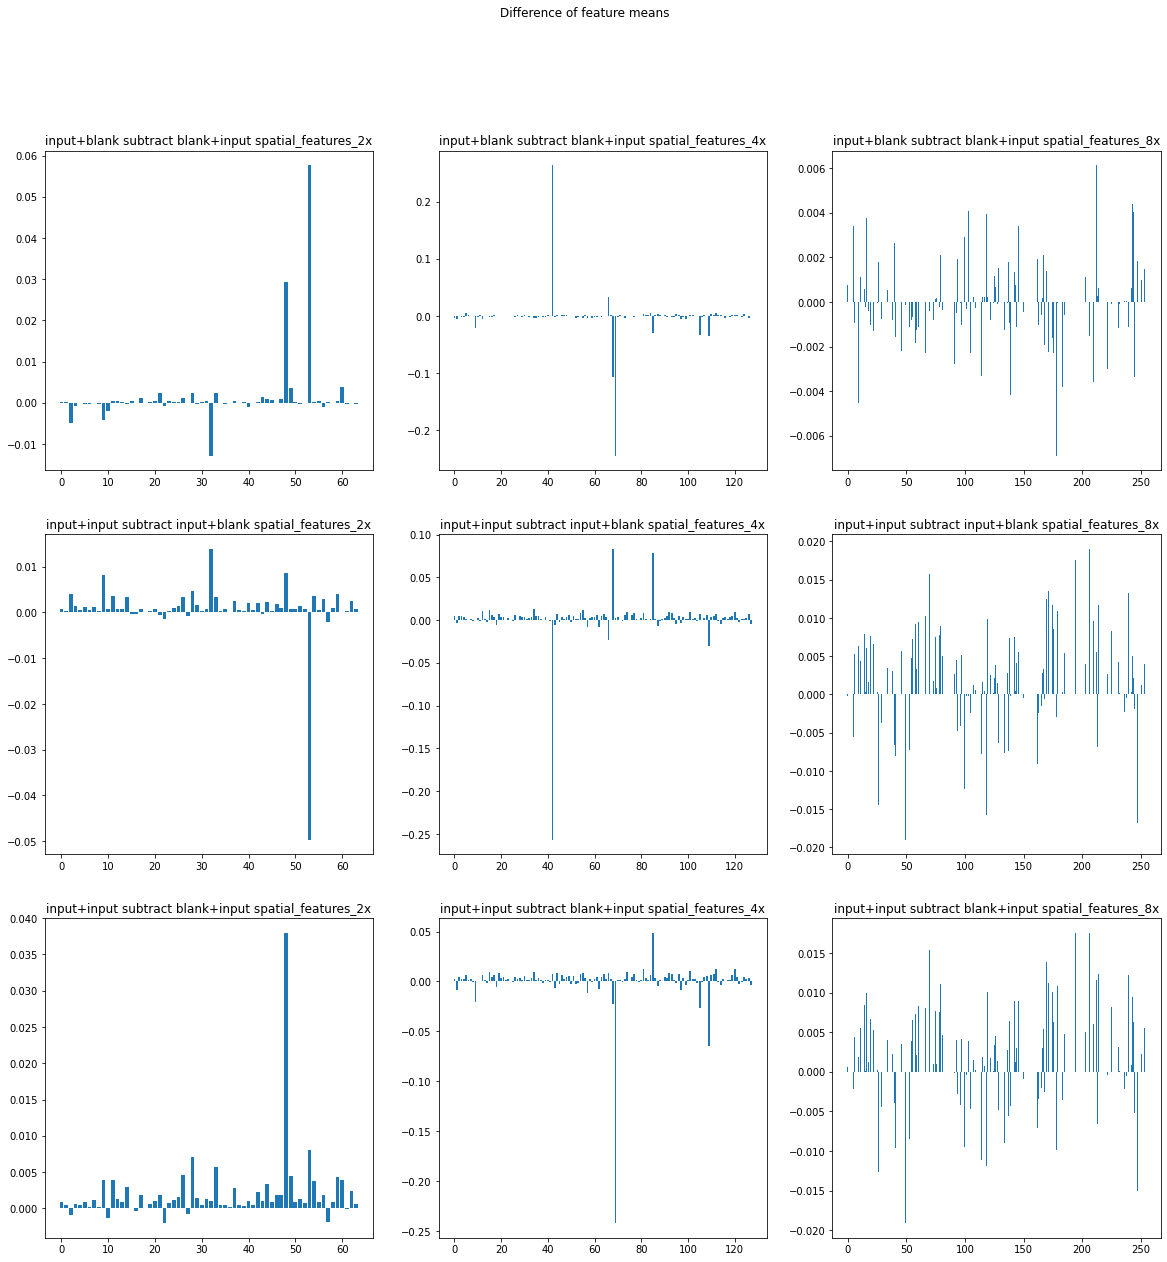

In [375]:
row_titles = ['input+blank subtract blank+input', \
              'input+input subtract input+blank', 'input+input subtract blank+input']
column_titles = ['spatial_features_2x', 'spatial_features_4x','spatial_features_8x']

feats_dicts_subtract_list = [
    [
        torch.mean(feats_dicts_list[1][0].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][0].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[1][1].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][1].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[1][2].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][2].float(), dim=(0, 2,3))
    ],
    [
        torch.mean(feats_dicts_list[0][0].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[1][0].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[0][1].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[1][1].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[0][2].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[1][2].float(), dim=(0, 2,3))
    ],
    [
        torch.mean(feats_dicts_list[0][0].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][0].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[0][1].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][1].float(), dim=(0, 2,3)),
        torch.mean(feats_dicts_list[0][2].float(), dim=(0, 2,3)) - torch.mean(feats_dicts_list[2][2].float(), dim=(0, 2,3))
    ]
]

n_rows = len(feats_dicts_subtract_list)
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_subtract_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

        test = feats

        ax = axes[row_num][col_num]
        if row_num == 0:
            print(np.argmax(test))
        ax.bar(x=np.arange(0,len(test)), height=test)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])

fig.suptitle('Difference of feature means')
plt.show()

In [166]:
head_outputs = []
for head_output_path in head_output_path_list:
    with open(head_output_path, 'rb') as f:
        head_output = pickle.load(f)
    cls_preds = head_output['cls_preds']
    box_preds = head_output['box_preds']
    var_preds = head_output['var_preds']
    head_output_list = [cls_preds, box_preds, var_preds]
    head_outputs.append(head_output_list)

torch.Size([1, 24, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 24, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 42, 248, 216])


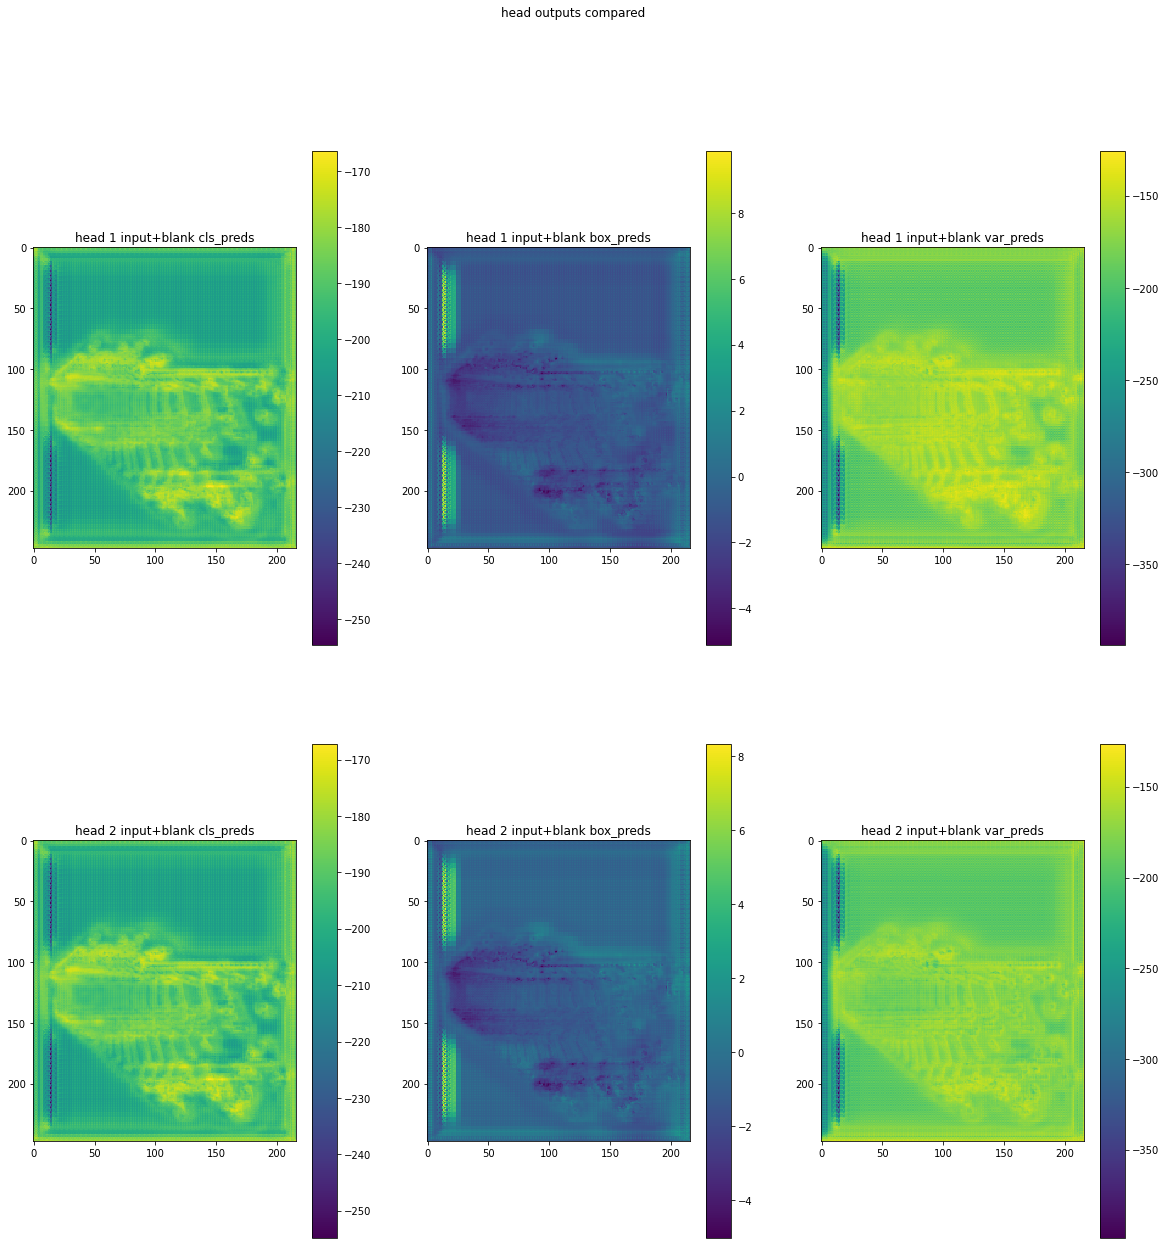

In [167]:
row_titles = ['head 1 input+blank', 'head 2 input+blank']
column_titles = ['cls_preds', 'box_preds','var_preds']

n_rows = len(head_outputs)
n_cols = 3
fig, axes = plt.subplots(2, 3, figsize=(20,20))

for row_num in range(n_rows):
    head_outputs_list = head_outputs[row_num]
    for col_num in range(n_cols):
        preds = head_outputs_list[col_num]
        print(preds.size())
        test = torch.sum(preds, dim=(0,1))

        ax = axes[row_num][col_num]
        im = ax.imshow(test, interpolation='none')
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])
        plt.colorbar(im,ax=ax)

fig.suptitle('head outputs compared')
plt.show()

torch.Size([1, 24, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 24, 248, 216])
torch.Size([1, 42, 248, 216])
torch.Size([1, 42, 248, 216])


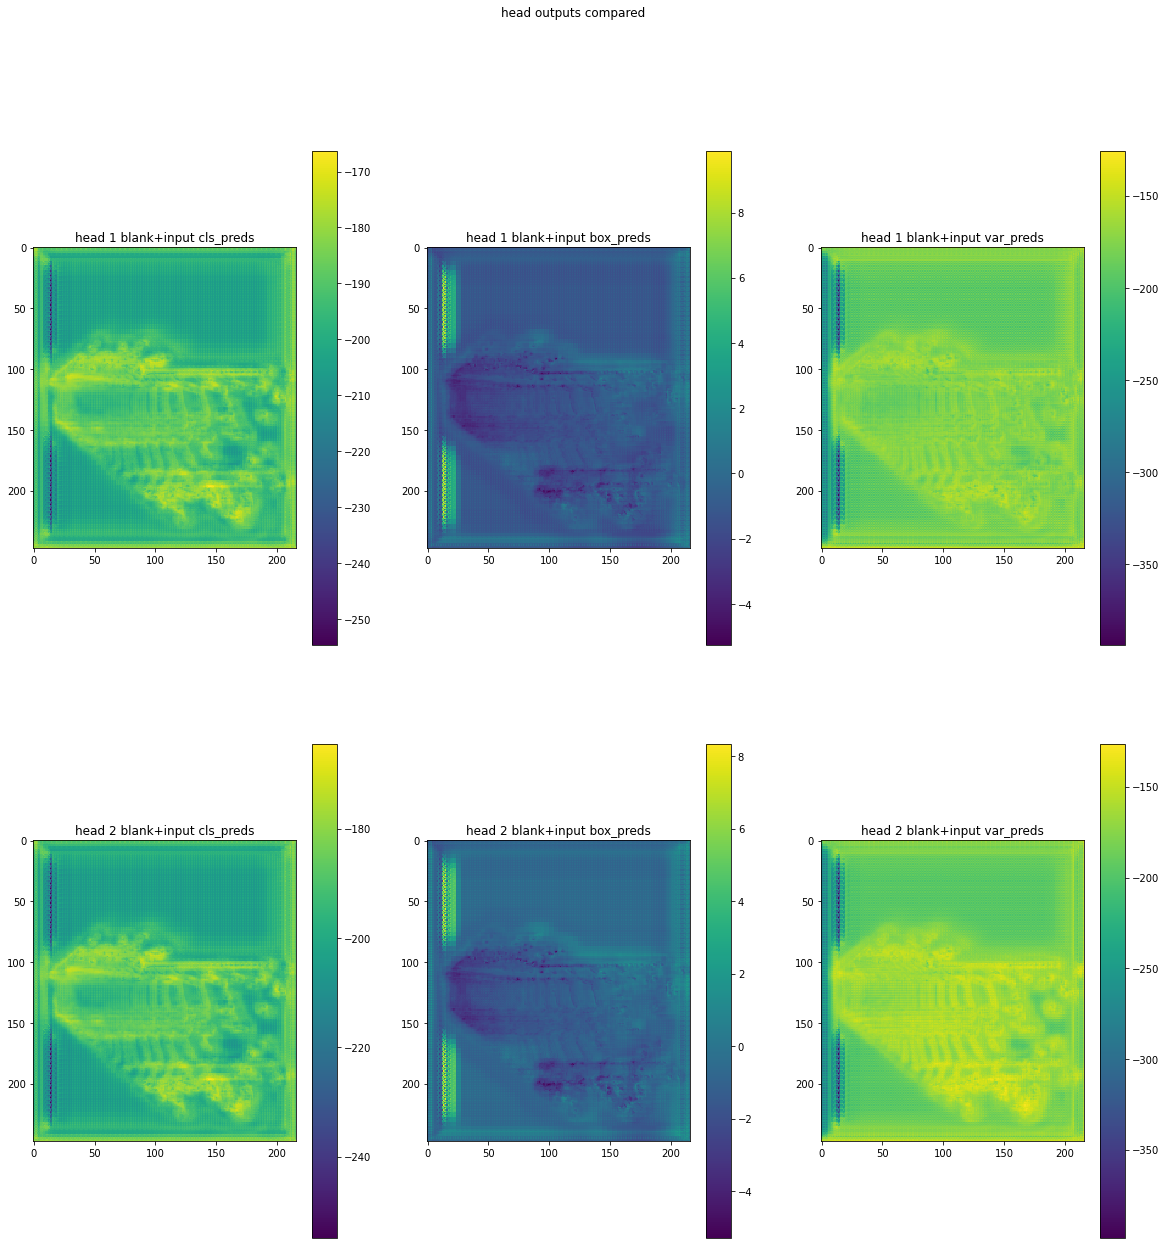

In [164]:
row_titles = ['head 1 blank+input', 'head 2 blank+input']
column_titles = ['cls_preds', 'box_preds','var_preds']

n_rows = len(head_outputs)
n_cols = 3
fig, axes = plt.subplots(2, 3, figsize=(20,20))

for row_num in range(n_rows):
    head_outputs_list = head_outputs[row_num]
    for col_num in range(n_cols):
        preds = head_outputs_list[col_num]
        print(preds.size())
        test = torch.sum(preds, dim=(0,1))

        ax = axes[row_num][col_num]
        im = ax.imshow(test, interpolation='none')
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])
        plt.colorbar(im,ax=ax)

fig.suptitle('head outputs compared')
plt.show()

In [358]:
# KITTI validation min max on features 2x, 4x, 8x
feats_2x_min = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
feats_2x_max = torch.tensor([ 9.1720,  6.2606,  5.9983,  6.5905, 12.9369,  4.0970,  6.0687,  6.7886,
        14.9057,  7.2227,  5.0902,  6.9052,  6.6027,  6.5319,  5.8524,  7.1428,
         9.0207,  5.0286,  8.8437,  6.6798,  5.1837,  6.1025,  7.1401,  6.1699,
         6.3592,  5.7723,  4.2303,  4.5774,  7.6125,  5.7421, 10.5580,  8.3038,
         2.9759,  4.0689,  5.2358,  7.3718, 12.3160,  8.2758, 13.2032,  5.3883,
         6.4977,  6.4980,  4.1359,  5.1444,  7.8972,  5.5503,  9.1256,  5.4156,
         3.1920,  5.4430,  9.1991,  8.3921,  5.6098,  2.3240, 11.4751,  5.0396,
         5.8714,  5.1088,  7.0267,  4.9790,  4.7931,  6.3157,  5.3691,  4.8899])
feats_4x_min = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
feats_4x_max = torch.tensor([3.3677, 1.9655, 2.4985, 3.5585, 4.3789, 5.0596, 4.0675, 5.3657, 3.4690,
        0.9532, 4.1739, 3.7775, 2.4305, 3.6433, 3.5645, 3.4446, 2.6987, 3.5462,
        2.0051, 4.6647, 3.5750, 2.9748, 6.3284, 4.6534, 4.4035, 3.0689, 2.6642,
        4.9583, 3.9505, 3.5894, 4.5034, 4.2074, 7.1153, 3.1889, 2.0625, 3.6910,
        3.5292, 2.8218, 3.9667, 5.2366, 2.9440, 4.2988, 1.0390, 2.4274, 3.5496,
        2.8386, 1.9416, 2.7040, 3.4554, 3.1059, 3.6282, 3.4910, 2.6685, 4.4130,
        2.2469, 3.0858, 2.0328, 1.6180, 6.2549, 2.3602, 3.6720, 2.2620, 1.8901,
        3.4622, 2.7353, 2.9501, 2.2436, 5.7546, 1.1902, 1.2826, 3.6900, 3.9431,
        3.4095, 2.2897, 2.7222, 4.7657, 3.2920, 3.1608, 3.4333, 3.9642, 3.0663,
        1.9940, 3.0697, 2.5791, 5.3565, 2.6656, 5.5030, 1.6341, 3.3378, 5.1688,
        2.1080, 2.8873, 3.4017, 3.1362, 6.6262, 2.7206, 3.1342, 1.9531, 2.5986,
        1.7371, 5.4098, 2.3635, 4.7586, 3.1603, 3.3115, 1.8036, 5.3344, 2.8962,
        2.8213, 1.2867, 3.0518, 2.1020, 1.8877, 3.9864, 3.6698, 3.8404, 1.7543,
        4.8647, 2.5127, 2.5818, 2.4387, 5.0779, 4.1801, 4.6809, 2.4154, 3.4525,
        3.1305, 3.3861])
feats_8x_min = torch.tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
feats_8x_max = torch.tensor([1.1719, 2.0745, 0.0000, 0.0000, 0.0000, 1.7284, 2.1561, 0.0834, 0.0000,
        0.4075, 0.0000, 1.0890, 0.0558, 0.0650, 2.1151, 0.3902, 2.2202, 0.0000,
        0.3045, 2.4699, 0.0000, 0.0000, 1.2139, 0.0000, 0.0000, 1.7206, 0.4113,
        0.0000, 0.1054, 3.1648, 0.0000, 0.0000, 0.0000, 0.0000, 0.3640, 0.1014,
        0.0769, 0.0289, 1.0265, 0.0079, 1.7472, 1.3271, 0.1074, 0.1737, 0.0000,
        0.0678, 2.7313, 0.0505, 0.1040, 1.7321, 0.0000, 0.1148, 0.0580, 0.6460,
        1.1677, 1.1033, 0.0509, 0.0000, 0.3315, 2.3186, 1.5774, 0.0832, 0.1306,
        0.0000, 0.0100, 1.0943, 1.0068, 0.1172, 0.0000, 0.0000, 0.9657, 0.0382,
        0.0885, 0.7170, 0.1022, 1.9316, 1.7345, 2.4462, 1.1102, 1.5833, 0.0000,
        1.3551, 0.1217, 0.0000, 0.0000, 0.0000, 0.0986, 0.0833, 0.0701, 0.1063,
        0.1507, 0.6364, 0.0000, 1.1015, 0.5586, 0.1339, 5.1317, 0.9357, 0.0187,
        0.1084, 1.3475, 4.9061, 0.0907, 0.9747, 0.0000, 1.6377, 0.0652, 0.8546,
        0.0000, 1.0369, 0.1142, 0.1023, 3.8347, 0.1655, 2.5980, 4.1086, 0.0000,
        0.9295, 1.4137, 0.9034, 0.0839, 0.0000, 0.5051, 0.0520, 0.9471, 1.1621,
        1.3049, 0.1113, 5.4967, 0.8872, 0.0834, 0.0000, 0.0000, 0.0654, 1.3470,
        0.1971, 1.5920, 1.0532, 1.6128, 0.7817, 0.0000, 0.1298, 1.7232, 1.6804,
        1.7015, 0.0000, 1.3917, 1.2770, 0.1030, 0.0000, 0.3705, 0.0000, 0.1328,
        2.8678, 0.1028, 0.0000, 0.0000, 0.1022, 0.0000, 0.0000, 0.1029, 0.0000,
        1.4461, 0.8372, 0.1637, 1.1844, 1.5387, 0.7406, 0.8220, 0.0000, 2.1000,
        0.5300, 0.2720, 0.0000, 0.0271, 1.2270, 1.9910, 0.1474, 0.5960, 2.8895,
        0.0961, 0.0760, 0.1039, 1.3146, 0.0815, 0.8089, 0.1387, 0.1126, 0.1625,
        0.1092, 0.0000, 0.0000, 0.0000, 0.0000, 1.3621, 0.0000, 0.0000, 0.1409,
        0.0000, 0.0000, 0.0638, 0.0695, 0.0678, 0.7986, 0.0000, 0.1225, 0.4220,
        0.0000, 0.1306, 0.0000, 0.5655, 0.0945, 0.5466, 3.9387, 0.3578, 0.0000,
        0.0000, 0.9431, 0.1101, 0.0000, 0.0000, 0.0882, 0.2250, 0.0000, 0.5515,
        1.8997, 0.0000, 0.1466, 0.1187, 0.0148, 0.0565, 1.6341, 1.0965, 0.1231,
        0.0000, 0.0000, 1.1823, 0.0000, 3.8688, 0.1009, 1.2162, 0.0000, 3.0967,
        2.5272, 0.7684, 1.0868, 0.0798, 1.9141, 0.0000, 0.0934, 0.0000, 1.0828,
        1.7648, 0.9560, 0.0420, 0.0000])

In [528]:
# https://discuss.pytorch.org/t/how-to-normalize-all-feature-maps-to-a-range-of-0-1/96753/4
feats_dicts_list = []
min_threshold = 0.3

def normalize_individual_feat_maps(feats):
    min_val = feats.min(-1)[0].min(-1)[0]
    max_val = feats.max(-1)[0].max(-1)[0]
    return (feats-min_val[:,:,None,None])/(max_val[:,:,None,None]-min_val[:,:,None,None])

def normalize_feat_maps(feats, number):
    if number == 2:
        print(feats.size())
        print(feats_2x_min.size())
        return (feats-feats_2x_min[None,:,None,None])/(feats_2x_max[None,:,None,None]-feats_2x_min[None,:,None,None])
    elif number == 4:
        return (feats-feats_4x_min[None,:,None,None])/(feats_4x_max[None,:,None,None]-feats_4x_min[None,:,None,None])
    elif number == 8:
        return (feats-feats_8x_min[None,:,None,None])/(feats_8x_max[None,:,None,None]-feats_8x_min[None,:,None,None])

for feats_dict_path in feats_dict_list:
    with open(feats_dict_path, 'rb') as f:
        feats_dicts = pickle.load(f)
    feats_2x = feats_dicts['spatial_features_2x'][:, :, 8:-8, 8:-8]
    feats_2x = normalize_feat_maps(feats_2x, 2)
#     feats_2x = feats_2x.ge(min_threshold).int()
    print('feats_2x', torch.sum(feats_2x))

    feats_4x = feats_dicts['spatial_features_4x'][:, :, 8:-8, 8:-8]
    feats_4x = normalize_feat_maps(feats_4x, 4)
#     feats_4x = feats_4x.ge(min_threshold).int()
    print('feats_4x', torch.sum(feats_4x))

    feats_8x = feats_dicts['spatial_features_8x'][:, :, 8:-8, 8:-8]
    feats_8x = normalize_feat_maps(feats_8x, 8)
#     feats_8x = feats_8x.ge(min_threshold).int()
    print('feats_8x', torch.sum(feats_8x))

    feats_list = [feats_2x, feats_4x, feats_8x]
    feats_dicts_list.append(feats_list)

# input+input & blank+blank
t = torch.sum((feats_dicts_list[0][0].bool() & feats_dicts_list[3][0].bool()).int())
print('input+input & blank+blank feats_2x', t)
t = torch.sum((feats_dicts_list[0][1].bool() & feats_dicts_list[3][1].bool()).int())
print('input+input & blank+blank feats_4x', t)
t = torch.sum((feats_dicts_list[0][2].bool() & feats_dicts_list[3][2].bool()).int())
print('input+input & blank+blank feats_8x', t)

# input+blank & blank+input
t = torch.sum((feats_dicts_list[1][0].bool() & feats_dicts_list[2][0].bool()).int())
print('input+blank & blank+input feats_2x', t)
t = torch.sum((feats_dicts_list[1][1].bool() & feats_dicts_list[2][1].bool()).int())
print('input+blank & blank+input feats_4x', t)
t = torch.sum((feats_dicts_list[1][2].bool() & feats_dicts_list[2][2].bool()).int())
print('input+blank & blank+input feats_8x', t)

# input+input & input+blank
t = torch.sum((feats_dicts_list[0][0].bool() & feats_dicts_list[1][0].bool()).int())
print('input+input & input+blank feats_2x', t)
t = torch.sum((feats_dicts_list[0][1].bool() & feats_dicts_list[1][1].bool()).int())
print('input+input & input+blank feats_4x', t)
t = torch.sum((feats_dicts_list[0][2].bool() & feats_dicts_list[1][2].bool()).int())
print('input+input & input+blank feats_8x', t)

# input+input & blank+input
t = torch.sum((feats_dicts_list[0][0].bool() & feats_dicts_list[2][0].bool()).int())
print('input+input & blank+input feats_2x', t)
t = torch.sum((feats_dicts_list[0][1].bool() & feats_dicts_list[2][1].bool()).int())
print('input+input & blank+input feats_4x', t)
t = torch.sum((feats_dicts_list[0][2].bool() & feats_dicts_list[2][2].bool()).int())
print('input+input & blank+input feats_8x', t)


torch.Size([1, 64, 232, 200])
torch.Size([64])
feats_2x tensor(94619.9766)
feats_4x tensor(67415.9688)
feats_8x tensor(nan)
torch.Size([1, 64, 232, 200])
torch.Size([64])
feats_2x tensor(92457.6641)
feats_4x tensor(65824.5000)
feats_8x tensor(nan)
torch.Size([1, 64, 232, 200])
torch.Size([64])
feats_2x tensor(88612.3594)
feats_4x tensor(67689.0781)
feats_8x tensor(nan)
torch.Size([1, 64, 232, 200])
torch.Size([64])
feats_2x tensor(76606.3828)
feats_4x tensor(53718.2422)
feats_8x tensor(nan)
input+input & blank+blank feats_2x tensor(1174542)
input+input & blank+blank feats_4x tensor(421011)
input+input & blank+blank feats_8x tensor(207977)
input+blank & blank+input feats_2x tensor(1305975)
input+blank & blank+input feats_4x tensor(632912)
input+blank & blank+input feats_8x tensor(241752)
input+input & input+blank feats_2x tensor(1301907)
input+input & input+blank feats_4x tensor(631574)
input+input & input+blank feats_8x tensor(238902)
input+input & blank+input feats_2x tensor(1300174)


In [529]:
row_titles = ['input+input', 'input+blank', 'blank+input', 'blank+blank']
column_titles = ['spatial_features_2x', 'spatial_features_4x','spatial_features_8x']

n_rows = len(feats_dicts_list)
n_cols = 3

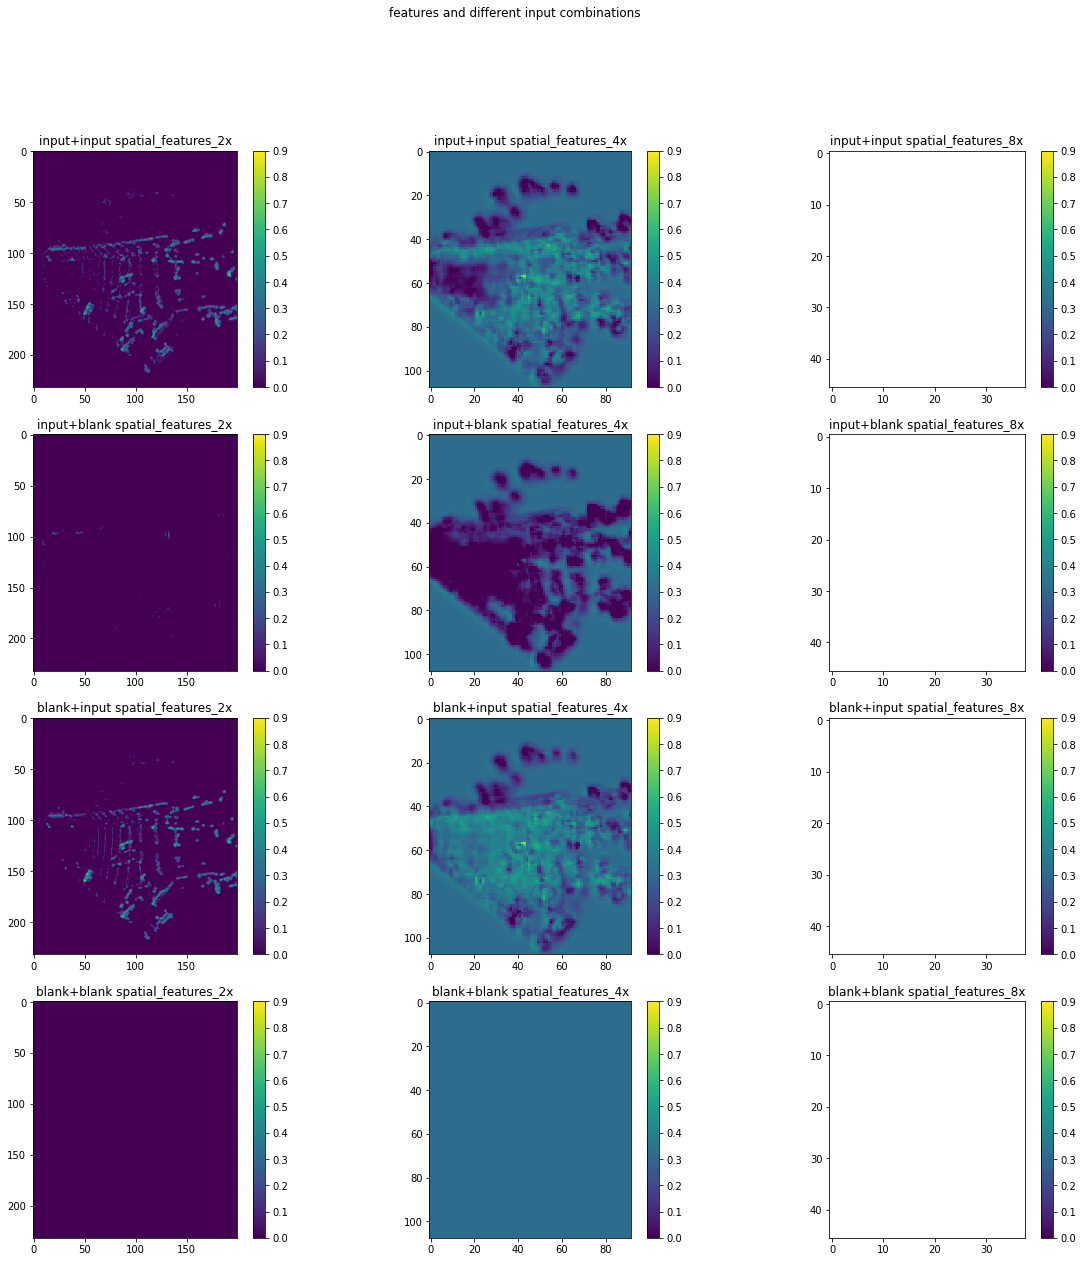

In [544]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for row_num in range(n_rows):
    feats_list = feats_dicts_list[row_num]
    for col_num in range(n_cols):
        feats = feats_list[col_num]

#         test = torch.mean(feats.float(), dim=(0,1))
        # Good to look for feat 2x: 53, 48, 32   [32, 63, 31, 48, 35, 13]
        # Good to look for feat 4x: 11, 42, 9?
        if col_num == 0:
            test = feats[0,32,:,:].float()
        elif col_num == 1:
            test = feats[0,68,:,:].float() # 68 was good
        else:
            test = feats[0,30,:,:].float()

        ax = axes[row_num][col_num]
        im = ax.imshow(test, interpolation='none', vmin=0, vmax=0.9)
        ax.set_title(row_titles[row_num] + ' ' + column_titles[col_num])
        plt.colorbar(im,ax=ax)

fig.suptitle('features and different input combinations')
plt.show()

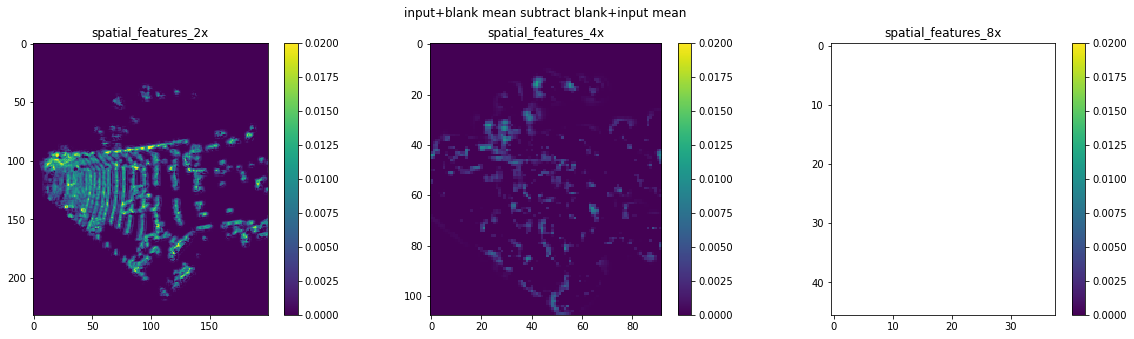

In [413]:
fig, axes = plt.subplots(1, n_cols, figsize=(20,5))

row_num = 1

feats_list_input_blank = feats_dicts_list[row_num]
feats_list_blank_input = feats_dicts_list[row_num +1]
for col_num in range(n_cols):
    A = torch.mean(feats_list_input_blank[col_num].float(), dim=(0,1))
    B = torch.mean(feats_list_blank_input[col_num].float(), dim=(0,1))
    subtraction = A - B

    ax = axes[col_num]
    im = ax.imshow(subtraction, interpolation='none', vmin=0, vmax=0.02)
    ax.set_title(column_titles[col_num])
    plt.colorbar(im,ax=ax)

fig.suptitle('input+blank mean subtract blank+input mean')
plt.show()